# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from enum import Enum
class GammaOption(Enum):
    MEAN_GAMMA = 1
    GAMMA_T = 2
    SEARCH = 3
    
#Run parameters
runForAllCountries = False
runWithGammaOption=GammaOption.GAMMA_T
#stepSizesToRunFor = [-1, 7, 21, 14]
stepSizesToRunFor = [7]

In [3]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [4]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values):
    if(S_E_I_R_values is not None):
        init_vals = S_E_I_R_values
    else:
        init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma,gammaT 
   
    t = np.arange(nSteps)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [5]:
def computeGamma(infected, removed, axs):    
    return computeGammaT(infected, removed, axs).mean()

In [6]:
def computeGammaT(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 1 # to prevent divide by zero
    gammaT = dR_dt / infected[1:]
    if len(gammaT[gammaT > 1]) > 0:
        print('gammaT', gammaT)
        print('infected', infected[1:])
        print('dR_dt', dR_dt)
    return gammaT

In [7]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.9
    l1_l2 =  weightForRecovered * l1 + (1 - weightForRecovered) * l2

    #Penalize negative values
    pred_infected = yhat[2,offsetOfyHat:]
    pred_removed = yhat[3,offsetOfyHat:]
    l3 = pred_infected [ pred_infected < 0]
    l4 = pred_removed [ pred_removed < 0]
    
    l3_l4 = (l3*l3).sum()+(l4*l4).sum() 
    if(l3_l4 >0):
        print("losses for negatives: l3_l4:",l3_l4,", l1_l2:", l1_l2, l3, l4)
    weightForNegatives = 0.9
    return (1-weightForNegatives)*l1_l2 + weightForNegatives * ( l3_l4 )
    

In [8]:
def estimateMultiStepSierParams(infected, removed, N, axs, stepSize):
    S_E_I_R_values = N-1, 1, 0, 0
    startIndex=0
    cumulativeAlphaHistory = []
    cumulativeBetaHistory = []
    cumulativeGammaHistory = []
    cumulativeLossHistory = []
    cumulativePredInfected = []
    cumulativePredRemoved = []
    cumulativeParams = []
    cumulativeMinLossHistory = []
    
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    if(stepSize == -1):
        stepSize = len(infected)
    while(startIndex < len(infected)):
        if(startIndex+(stepSize) > len(infected)):
            endIndex = len(infected)
        else:
            endIndex = (startIndex + (stepSize))
        if(endIndex - startIndex < 2):
            break
        infectedDf=infected[startIndex : endIndex]
        removedDf = removed[startIndex : endIndex]
        global runWithGammaOption
        S_E_I_R_values, params, alphaHistory, betaHistory, gammaHistory, lossHistory, predInfected, predRemoved, minLoss = estimateSingleStepSierParams(S_E_I_R_values, infectedDf, removedDf, N, axs, runWithGammaOption)
        cumulativeAlphaHistory.extend(alphaHistory)
        cumulativeBetaHistory.extend(betaHistory)
        cumulativeGammaHistory.extend(gammaHistory)
        cumulativeLossHistory.extend(lossHistory)
        cumulativePredInfected.extend(predInfected)
        cumulativePredRemoved.extend(predRemoved)
        cumulativeMinLossHistory.append(minLoss)
        cumulativeParams.append(params)
        startIndex = endIndex
        
    axs[0].plot(cumulativePredInfected, label = 'Pred-Infected')
    axs[0].set_title('pred-infected & infected')
    axs[0].plot(infected, label = 'Infected')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[0].legend(loc="upper right")
    axs[1].plot(cumulativePredRemoved, label='Pred-Removed')
    axs[1].set_title('pred-removed & removed')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].plot(removed, label = 'Removed')
    axs[1].legend(loc="upper right")
    axs[1].set_xticks(np.arange(0, (len(removed)+1), 10.0))
    axs[2].tick_params(axis='x', rotation=90)
    axs[2].plot(cumulativeMinLossHistory, label = 'cumulativeMinLossHistory')
    axs[2].legend(loc="upper right")
    
    
    return cumulativeParams, np.sum(cumulativeMinLossHistory)

In [9]:
def estimateSingleStepSierParams(S_E_I_R_values, infected, removed, N, axs, gammaOption):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,1)
    
    nSteps = len(infected)
    gammaT = None
    if(gammaOption == GammaOption.MEAN_GAMMA):
        gammaMean = computeGamma(infected, removed, axs)
    elif(gammaOption == GammaOption.GAMMA_T):
        gammaT = computeGammaT(infected, removed, axs)
        print("gammaT", gammaT)
    elif(gammaOption == GammaOption.SEARCH):
        gammaSpace = np.arange(0.001,1,0.05)
        
    for alpha in alphaSpace:
        for beta in betaSpace:
            for gamma in gammaSpace:
                if(gammaOption == GammaOption.MEAN_GAMMA):
                    gamma = gammaMean
                elif(gammaOption == GammaOption.GAMMA_T):
                    gamma = None
                yhat = (predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values))
                loss = computeLoss(yhat, infected, removed)
                if(loss < minLoss) or (minLoss == -1):
                    minLoss = loss
                    if(gamma != None):
                        minParams = [alpha, beta, gamma]
                    else:
                        minParams = [alpha, beta, gammaT]
                    minYhat = yhat
                lossHistory.append(loss)
                alphaHistory.append(alpha)
                betaHistory.append(beta)
                if(gamma != None):
                    gammaHistory.append(gamma)
                else:
                    gammaHistory.append(gammaT)
    S_E_I_R_values = int(minYhat[0, -1]), int(minYhat[1, -1]),int(minYhat[2, -1]),int(minYhat[3, -1])
    return S_E_I_R_values, minParams, alphaHistory, betaHistory, gammaHistory, lossHistory, minYhat[2,0:], minYhat[3,0:], minLoss



## Run it for countries

In [10]:
from pandas import *
cumulativeLossDf = DataFrame({'Country': [], 'Accuracy_Score': [], 'Step_Size': []})

def computeParamsWithStepSize(stepSize):
    if runForAllCountries:
        countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom"])
    else:
        countries = list(["India",  "Pakistan"])
    global cumulativeLossDf
    pyplot.figure(1)
    paramsResultDf = DataFrame({'Country': [], 'Params': []})
    
    for country in countries:
        fig, axs = pyplot.subplots(1,3)
        fig.set_size_inches(30, 5)
        fig.suptitle(country+"    step-size="+str(stepSize))
        N = int(populationDf [populationDf['Country']==country]['Population'])
        confirmedTSDf = confirmedDf.loc[confirmedDf["Country/Region"] == country].sum().T[4:]
        recoveredTSDf = recoveredDf.loc[recoveredDf["Country/Region"] == country].sum().T[4:]
        deathsTSDf = deathsDf.loc[deathsDf["Country/Region"] == country].sum().T[4:]
        activeTSDf = confirmedTSDf-recoveredTSDf-deathsTSDf
        #print('activeTSDf '+country, activeTSDf)
        #print('removedTSDf '+country, (recoveredTSDf+deathsTSDf))
        params, cumulativeLoss = estimateMultiStepSierParams(activeTSDf, (recoveredTSDf+deathsTSDf), N, axs, stepSize)
        paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)
        cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)
        fig, axs = pyplot.subplots(1,3)
        fig.set_size_inches(18.5, 5)
        alphas = []
        betas = []
        gammas = []
        for param in params:
            alphas.append(param[0])
            betas.append(param[1])
            gammas.extend(param[2])
        axs[0].plot(alphas, label = 'Alphas')
        axs[0].set_title('Alphas')
        axs[1].plot(betas, label = 'Betas')
        axs[1].set_title('Betas')
        axs[2].plot(gammas, label = 'Gammas')
        axs[2].set_title('Gammas')
        
        

    fig, axs = pyplot.subplots(1,3)
    fig.set_size_inches(18.5, 5)    
    N = int(populationDf [populationDf['Country']=='United States']['Population'])
    params_us, cumulativeLoss = estimateMultiStepSierParams(total_infected_us_timeseries, total_removed_us_timeseries, N, axs, stepSize)
    country = "The United States"
    fig.suptitle(country)
    paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params_us}, ignore_index=True)
    cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)
    pandas.set_option('display.max_colwidth', -1)
    display(paramsResultDf)

gammaT 1/31/20    0
2/1/20     0
2/2/20     0
2/3/20     0
2/4/20     0
2/5/20     0
dtype: object
gammaT 2/7/20     0
2/8/20     0
2/9/20     0
2/10/20    0
2/11/20    0
2/12/20    0
dtype: object
gammaT 2/14/20    0
2/15/20    0
2/16/20    3
2/17/20    0
2/18/20    0
2/19/20    0
dtype: object
infected 2/14/20    3
2/15/20    3
2/16/20    1
2/17/20    1
2/18/20    1
2/19/20    1
dtype: object
dR_dt [0 0 3 0 0 0]
gammaT 2/14/20    0
2/15/20    0
2/16/20    3
2/17/20    0
2/18/20    0
2/19/20    0
dtype: object
losses for negatives: l3_l4: 144.07191856558595 , l1_l2: 190.90436013496443 [-6.003      -6.001994   -6.00099502 -6.00000303] []
losses for negatives: l3_l4: 144.05396647502255 , l1_l2: 190.88767357766133 [-6.0030001  -6.0015444  -6.0003963  -5.99955543] []
losses for negatives: l3_l4: 144.03601428803626 , l1_l2: 190.8709868933076 [-6.0030002  -6.00109477 -5.99979755 -5.99910774] []
losses for negatives: l3_l4: 144.01806200498964 , l1_l2: 190.85430008222536 [-6.0030003  -6.00064

losses for negatives: l3_l4: 161.17722446293004 , l1_l2: 216.22595266109477 [-6.6070805  -6.26400849 -6.19042544 -6.32175152] []
losses for negatives: l3_l4: 159.18242095896628 , l1_l2: 214.70165780049456 [-6.6111206  -6.18717968 -6.11554677 -6.30828032] []
losses for negatives: l3_l4: 157.15486218049307 , l1_l2: 213.1479268204681 [-6.6151607  -6.10974487 -6.03965908 -6.29190328] []
losses for negatives: l3_l4: 155.09534543501508 , l1_l2: 211.56544440934024 [-6.6192008  -6.03170403 -5.96276238 -6.27260213] []
losses for negatives: l3_l4: 153.00473025318965 , l1_l2: 209.95495125627366 [-6.6232409  -5.95305719 -5.88485666 -6.25035858] []
losses for negatives: l3_l4: 150.88393946071514 , l1_l2: 208.31724501596767 [-6.627281   -5.87380432 -5.80594193 -6.22515438] []
losses for negatives: l3_l4: 148.73396025689811 , l1_l2: 206.65318127936928 [-6.6313211  -5.79394545 -5.72601818 -6.19697125] []
losses for negatives: l3_l4: 146.55584529989582 , l1_l2: 204.96367455039092 [-6.6353612  -5.713480

losses for negatives: l3_l4: 190.77404000244718 , l1_l2: 259.79587752748137 [-7.2514011  -6.15503994 -6.51896155 -7.60327862] []
losses for negatives: l3_l4: 189.09166677768664 , l1_l2: 259.4706257039249 [-7.2674812  -6.01754793 -6.43745613 -7.65660886] []
losses for negatives: l3_l4: 187.24884566814393 , l1_l2: 259.0060562547722 [-7.2835613  -5.8776439  -6.35273871 -7.70029827] []
losses for negatives: l3_l4: 185.24446261822894 , l1_l2: 258.4009053811486 [-7.2996414  -5.73532786 -6.26480929 -7.73420176] []
losses for negatives: l3_l4: 183.07802997868444 , l1_l2: 257.6544730498793 [-7.3157215  -5.5905998  -6.17366787 -7.75817425] []
losses for negatives: l3_l4: 180.7497151124256 , l1_l2: 256.7666487387455 [-7.3318016  -5.44345973 -6.07931445 -7.77207066] []
losses for negatives: l3_l4: 178.26036942135798 , l1_l2: 255.7379375606202 [-7.3478817  -5.29390765 -5.98174903 -7.7757459 ] []
losses for negatives: l3_l4: 175.6115577941752 , l1_l2: 254.56948676648597 [-7.3639618  -5.14194354 -5.8

losses for negatives: l3_l4: 251.84224918927512 , l1_l2: 339.9927016825382 [-7.9478416  -5.90478316 -7.48270588 -9.89023314] []
losses for negatives: l3_l4: 252.4749302919504 , l1_l2: 343.2209613424135 [ -7.9839617   -5.71096196  -7.44793193 -10.03217371] []
losses for negatives: l3_l4: 252.70166678892315 , l1_l2: 346.1033056074241 [ -8.0200818   -5.51172274  -7.40774901 -10.15510324] []
losses for negatives: l3_l4: 252.50619608610745 , l1_l2: 348.62421896164864 [ -8.0562019   -5.3070655   -7.36215709 -10.25853331] []
losses for negatives: l3_l4: 251.87444686596288 , l1_l2: 350.7701580380588 [ -8.092322    -5.09699025  -7.3111562  -10.34197549] []
losses for negatives: l3_l4: 250.7947319571969 , l1_l2: 352.5297252012509 [ -8.1284421   -4.88149699  -7.25474632 -10.40494133] []
losses for negatives: l3_l4: 249.2579459758218 , l1_l2: 353.893846424397 [ -8.1645622   -4.66058571  -7.19292745 -10.44694241] []
losses for negatives: l3_l4: 247.25776773756957 , l1_l2: 354.8559534604189 [ -8.200

losses for negatives: l3_l4: 368.96515210843324 , l1_l2: 499.66052386386684 [ -8.9810825   -4.28463367  -9.47200415 -13.42491568] []
losses for negatives: l3_l4: 369.9140895614987 , l1_l2: 505.3084365980645 [ -9.0452426   -3.98651522  -9.50778901 -13.48359449] []
losses for negatives: l3_l4: 369.8655229863191 , l1_l2: 510.09313293836124 [ -9.1094027   -3.67877275  -9.5371739  -13.50530453] []
losses for negatives: l3_l4: 252.03917610261124 , l1_l2: 321.08167349800584 [-7.93815335 -7.93140602 -7.93715604 -7.94476242] []
losses for negatives: l3_l4: 263.2584313863764 , l1_l2: 335.4460952962474 [-8.01057345 -7.80167291 -8.11821362 -8.50397859] []
losses for negatives: l3_l4: 274.622447757064 , l1_l2: 350.02481783535353 [-8.08299355 -7.66107677 -8.29295255 -9.04557924] []
losses for negatives: l3_l4: 286.04998323782223 , l1_l2: 364.74222734127227 [-8.15541365 -7.50961762 -8.46137282 -9.56817771] []
losses for negatives: l3_l4: 297.4570110324645 , l1_l2: 379.52020370255315 [ -8.22783375  -7

losses for negatives: l3_l4: 279.1971660880124 , l1_l2: 381.22557761161045 [-5.         -5.408      -5.820947   -6.24069031 -6.66901041 -7.10763198
 -7.55823593] []
losses for negatives: l3_l4: 285.83988235373147 , l1_l2: 388.0353274293058 [-5.         -5.408      -5.833697   -6.27933046 -6.74716192 -7.23949109
 -7.75867137] []
losses for negatives: l3_l4: 292.6343285154343 , l1_l2: 394.984077540831 [-5.         -5.408      -5.846447   -6.31797061 -6.82537845 -7.371674
 -7.96007543] []
losses for negatives: l3_l4: 299.5819705104675 , l1_l2: 402.07314818519774 [-5.         -5.408      -5.859197   -6.35661076 -6.90366    -7.5041807
 -8.1624486 ] []
losses for negatives: l3_l4: 306.684281369108 , l1_l2: 409.30386598505487 [-5.         -5.408      -5.871947   -6.39525091 -6.98200658 -7.63701121
 -8.36579138] []
losses for negatives: l3_l4: 313.942741224207 , l1_l2: 416.67756395536856 [-5.         -5.408      -5.884697   -6.43389106 -7.06041819 -7.77016551
 -8.57010427] []
losses for negati

losses for negatives: l3_l4: 1003.3503456883146 , l1_l2: 1094.847345893595 [ -5.          -7.008       -8.889747   -10.82863691 -12.95249473
 -15.36137859 -18.14420653] []
losses for negatives: l3_l4: 1086.56959364588 , l1_l2: 1174.3849710844281 [ -5.          -7.008       -8.952497   -11.02633706 -13.36836721
 -16.09397911 -19.31322896] []
losses for negatives: l3_l4: 1175.269801546617 , l1_l2: 1258.9134315150848 [ -5.          -7.008       -9.015247   -11.22403721 -13.78581471
 -16.83429663 -20.50516563] []
losses for negatives: l3_l4: 1269.6556425143312 , l1_l2: 1348.6170397366316 [ -5.          -7.008       -9.077997   -11.42173736 -14.20483723
 -17.58233114 -21.72007587] []
losses for negatives: l3_l4: 1369.9358994833442 , l1_l2: 1443.6838071296027 [ -5.          -7.008       -9.140747   -11.61943751 -14.62543478
 -18.33808264 -22.95801895] []
losses for negatives: l3_l4: 1476.3234924802205 , l1_l2: 1544.3054684575548 [ -5.          -7.008       -9.203497   -11.81713766 -15.047607

losses for negatives: l3_l4: 822.428409488797 , l1_l2: 923.787865908606 [ -5.          -8.608      -10.591047   -11.68362201 -12.28822225
 -12.6254171  -12.81607906] []
losses for negatives: l3_l4: 934.3535464761584 , l1_l2: 1032.1809213243353 [ -5.          -8.608      -10.703797   -12.05238216 -13.03895345
 -13.85779793 -14.60725252] []
losses for negatives: l3_l4: 1060.3142461441691 , l1_l2: 1153.3839190971757 [ -5.          -8.608      -10.816547   -12.42114231 -13.79476967
 -15.11468654 -16.46768646] []
losses for negatives: l3_l4: 1201.3041749118179 , l1_l2: 1288.2917782083848 [ -5.          -8.608      -10.929297   -12.78990246 -14.55567091
 -16.39608294 -18.3977249 ] []
losses for negatives: l3_l4: 1358.355042806461 , l1_l2: 1437.8336568867724 [ -5.          -8.608      -11.042047   -13.15866261 -15.32165718
 -17.70198713 -20.39771183] []
losses for negatives: l3_l4: 1532.537083529503 , l1_l2: 1602.973384667812 [ -5.          -8.608      -11.154797   -13.52742276 -16.09272848
 

losses for negatives: l3_l4: 4807.842939588547 , l1_l2: 4657.420113549995 [ -5.          -9.808      -13.532397   -18.56109081 -25.455455
 -34.91059096 -47.87772618] []
losses for negatives: l3_l4: 5409.243736204608 , l1_l2: 5212.331601476737 [ -5.          -9.808      -13.682647   -19.06602097 -26.56733653
 -37.01996131 -51.5850558 ] []
losses for negatives: l3_l4: 6068.002356488932 , l1_l2: 5819.187623846703 [ -5.          -9.808      -13.832897   -19.57095112 -27.68824809
 -39.17231097 -55.41953894] []
losses for negatives: l3_l4: 6787.756658889477 , l1_l2: 6481.26371856718 [ -5.          -9.808      -13.983147   -20.07588127 -28.81818967
 -41.36763994 -59.38198966] []
losses for negatives: l3_l4: 7572.279718583353 , l1_l2: 7201.957118601748 [ -5.          -9.808      -14.133397   -20.58081142 -29.95716127
 -43.60594822 -63.47322202] []
losses for negatives: l3_l4: 8425.48191756507 , l1_l2: 7984.788633049711 [ -5.          -9.808      -14.283647   -21.08574157 -31.10516291
 -45.8872

losses for negatives: l3_l4: 6364.756745360434 , l1_l2: 6096.804005966085 [ -5.         -11.008      -14.760747   -20.66365282 -28.79575432
 -40.14720808 -55.97071286] []
losses for negatives: l3_l4: 7261.785163296065 , l1_l2: 6921.615197926226 [ -5.         -11.008      -14.948497   -21.31150297 -30.20422663
 -42.83773008 -60.7503494 ] []
losses for negatives: l3_l4: 8256.048521308792 , l1_l2: 7834.428906908482 [ -5.         -11.008      -15.136247   -21.95935312 -31.62679897
 -45.59451657 -65.72243864] []
losses for negatives: l3_l4: 9354.729775006024 , l1_l2: 8841.712652025066 [ -5.         -11.008      -15.323997   -22.60720327 -33.06347133
 -48.41756754 -70.88856892] []
losses for negatives: l3_l4: 10565.3297483553 , l1_l2: 9950.220033912443 [ -5.         -11.008      -15.511747   -23.25505342 -34.51424372
 -51.30688299 -76.25032864] []
losses for negatives: l3_l4: 11895.673323095463 , l1_l2: 11166.996305201375 [ -5.         -11.008      -15.699497   -23.90290357 -35.97911613
 -54

losses for negatives: l3_l4: 12109.651099586175 , l1_l2: 11367.292626606522 [ -5.         -12.208      -16.304847   -24.97099027 -36.86162958
 -54.93544871 -81.66721609] []
losses for negatives: l3_l4: 13822.006662230135 , l1_l2: 12931.756230386693 [ -5.         -12.208      -16.530097   -25.76851043 -38.612901
 -58.48165576 -88.31563269] []
losses for negatives: l3_l4: 15721.024975423237 , l1_l2: 14664.917013954542 [ -5.         -12.208      -16.755347   -26.56603058 -40.38446745
 -62.12202362 -95.23887362] []
losses for negatives: l3_l4: 17820.9564443707 , l1_l2: 16579.605279171723 [  -5.          -12.208       -16.980597    -27.36355073  -42.17632892
  -65.85655229 -102.43968175] []
losses for negatives: l3_l4: 20136.724381600077 , l1_l2: 18689.256944490236 [  -5.          -12.208       -17.205847    -28.16107089  -43.98848542
  -69.68524176 -109.92079996] []
losses for negatives: l3_l4: 1032.357597363266 , l1_l2: 1129.150902135946 [ -5.         -12.608      -12.985547   -13.0160370

losses for negatives: l3_l4: 332.26955224362416 , l1_l2: 1389.5148876713747 [-5.         -5.707      -6.343098   -6.91552651 -7.43078039 -7.8946921
 -8.31249923] []
losses for negatives: l3_l4: 346.8970645626875 , l1_l2: 1422.1203395302903 [-5.         -5.707      -6.368348   -6.99229661 -7.58602977 -8.1558132
 -8.70712414] []
losses for negatives: l3_l4: 362.12680145984746 , l1_l2: 1455.4412524402821 [-5.         -5.707      -6.393598   -7.06906671 -7.74153417 -8.41819397
 -9.10548252] []
losses for negatives: l3_l4: 377.9699809757001 , l1_l2: 1489.4878965016376 [-5.         -5.707      -6.418848   -7.14583681 -7.8972936  -8.68183441
 -9.50757823] []
losses for negatives: l3_l4: 394.4379272382411 , l1_l2: 1524.2706372933076 [-5.         -5.707      -6.444098   -7.22260691 -8.05330805 -8.94673452
 -9.91341513] []
losses for negatives: l3_l4: 411.5420707518085 , l1_l2: 1559.7999361329576 [ -5.          -5.707       -6.469348    -7.29937701  -8.20957753
  -9.2128943  -10.32299709] []
los

losses for negatives: l3_l4: 1538.9082416578021 , l1_l2: 3328.6787588157563 [ -5.          -6.757       -8.889998   -11.59171406 -15.06793396
 -19.56572035 -25.39667787] []
losses for negatives: l3_l4: 1654.436907846018 , l1_l2: 3495.063965008866 [ -5.          -6.757       -8.952748   -11.78626416 -15.48381274
 -20.3270816  -26.67908237] []
losses for negatives: l3_l4: 1776.4977846996335 , l1_l2: 3668.392479579929 [ -5.          -6.757       -9.015498   -11.98081426 -15.90126654
 -21.09608079 -27.98440135] []
losses for negatives: l3_l4: 1905.312999378783 , l1_l2: 3848.866885463597 [ -5.          -6.757       -9.078248   -12.17536436 -16.32029537
 -21.8727179  -29.31269413] []
losses for negatives: l3_l4: 2041.108835423862 , l1_l2: 4036.6935063368383 [ -5.          -6.757       -9.140998   -12.36991446 -16.74089922
 -22.65699293 -30.66402001] []
losses for negatives: l3_l4: 2184.1157600375554 , l1_l2: 4232.082431172767 [ -5.          -6.757       -9.203748   -12.56446456 -17.16307809


losses for negatives: l3_l4: 2655.3014511378037 , l1_l2: 4780.287722290917 [ -5.          -8.157      -11.132698   -14.79337886 -19.56957925
 -25.86788274 -34.18871144] []
losses for negatives: l3_l4: 2949.1713077994873 , l1_l2: 5163.738866890633 [ -5.          -8.157      -11.245448   -15.15196896 -20.34473891
 -27.30252599 -36.63681302] []
losses for negatives: l3_l4: 3267.7742072216615 , l1_l2: 5572.745721418211 [ -5.          -8.157      -11.358198   -15.51055906 -21.12498359
 -28.76121836 -39.15582767] []
losses for negatives: l3_l4: 3612.444944284738 , l1_l2: 6008.525081371455 [ -5.          -8.157      -11.470948   -15.86914916 -21.9103133
 -30.24395985 -41.74609941] []
losses for negatives: l3_l4: 3984.559435268494 , l1_l2: 6472.330751508121 [ -5.          -8.157      -11.583698   -16.22773926 -22.70072804
 -31.75075046 -44.40797222] []
losses for negatives: l3_l4: 4385.535209287885 , l1_l2: 6965.453988138171 [ -5.          -8.157      -11.696448   -16.58632936 -23.4962278
 -33

losses for negatives: l3_l4: 1305.9506230355425 , l1_l2: 2838.467440633972 [ -5.          -9.557      -11.638898   -13.30494306 -15.0305081
 -16.94061951 -19.08476237] []
losses for negatives: l3_l4: 1525.9343032383654 , l1_l2: 3165.4171334788516 [ -5.          -9.557      -11.801648   -13.83557316 -16.08967048
 -18.68674904 -21.69847894] []
losses for negatives: l3_l4: 1777.3785118990568 , l1_l2: 3526.8742158222026 [ -5.          -9.557      -11.964398   -14.36620326 -17.1594279
 -20.48171528 -24.44506128] []
losses for negatives: l3_l4: 2063.1233170171568 , l1_l2: 3925.441306084911 [ -5.          -9.557      -12.127148   -14.89683336 -18.23978033
 -22.32551823 -27.32554399] []
losses for negatives: l3_l4: 2386.1546354289667 , l1_l2: 4363.852286642478 [ -5.          -9.557      -12.289898   -15.42746346 -19.3307278
 -24.2181579  -30.34096168] []
losses for negatives: l3_l4: 2749.6070141926098 , l1_l2: 4844.974807071594 [ -5.          -9.557      -12.452648   -15.95809356 -20.43227028


losses for negatives: l3_l4: 5240.071140739788 , l1_l2: 7902.556902709171 [ -5.         -10.607      -13.929548   -19.27214511 -26.48314191
 -36.42391089 -50.0904853 ] []
losses for negatives: l3_l4: 6035.055747763416 , l1_l2: 8842.998123131907 [ -5.         -10.607      -14.129798   -19.93705521 -27.89479833
 -39.07610764 -54.72977229] []
losses for negatives: l3_l4: 6923.502864119856 , l1_l2: 9877.106644027794 [ -5.         -10.607      -14.330048   -20.60196532 -29.32249477
 -41.80079569 -59.57422215] []
losses for negatives: l3_l4: 7912.9474872763485 , l1_l2: 11011.750687599313 [ -5.         -10.607      -14.530298   -21.26687542 -30.76623124
 -44.59797504 -64.6257621 ] []
losses for negatives: l3_l4: 9011.291300214507 , l1_l2: 12254.1284930152 [ -5.         -10.607      -14.730548   -21.93178552 -32.22600773
 -47.46764567 -69.88631934] []
losses for negatives: l3_l4: 10226.810690701006 , l1_l2: 13611.775533754146 [ -5.         -10.607      -14.930798   -22.59669562 -33.70182425
 -

losses for negatives: l3_l4: 11439.345598476299 , l1_l2: 14919.10749923876 [ -5.         -11.657      -15.554198   -24.07060177 -35.59672941
 -53.35275781 -79.64602371] []
losses for negatives: l3_l4: 13113.110020272065 , l1_l2: 16746.673968850944 [ -5.         -11.657      -15.791948   -24.87429188 -37.34885901
 -56.90812986 -86.31706575] []
losses for negatives: l3_l4: 14976.402743422132 , l1_l2: 18758.25717715482 [ -5.         -11.657      -16.029698   -25.67798198 -39.12359864
 -60.56365075 -93.27698192] []
losses for negatives: l3_l4: 17044.37281145127 , l1_l2: 20967.63640286706 [  -5.          -11.657       -16.267448    -26.48167208  -40.92094829
  -64.3193205  -100.52899753] []
losses for negatives: l3_l4: 19332.92781957963 , l1_l2: 23389.27362123634 [  -5.          -11.657       -16.505198    -27.28536218  -42.74090796
  -68.1751391  -108.07633791] []
gammaT 3/6/20             0
3/7/20             0
3/8/20             0
3/9/20             0
3/10/20    0.0192308
3/11/20    0.01

losses for negatives: l3_l4: 539.5069963481434 , l1_l2: 15156.214180088056 [ -5.          -5.606       -6.504799    -7.70972971  -9.25350869
 -11.00927048 -13.20969184] []
losses for negatives: l3_l4: 561.5411755487473 , l1_l2: 15263.198506067305 [ -5.          -5.606       -6.530049    -7.78598976  -9.41039125
 -11.28033424 -13.63999117] []
losses for negatives: l3_l4: 584.2935196952603 , l1_l2: 15371.347323207958 [ -5.          -5.606       -6.555299    -7.86224981  -9.56752883
 -11.55264761 -14.07402188] []
losses for negatives: l3_l4: 607.7761402974584 , l1_l2: 15480.671928412954 [ -5.          -5.606       -6.580549    -7.93850986  -9.72492144
 -11.8262106  -14.51178784] []
losses for negatives: l3_l4: 632.0012558102298 , l1_l2: 15591.18371483627 [ -5.          -5.606       -6.605799    -8.01476991  -9.88256907
 -12.1010232  -14.95329291] []
losses for negatives: l3_l4: 656.9811919223572 , l1_l2: 15702.894172142847 [ -5.          -5.606       -6.631049    -8.09102996 -10.04047173


losses for negatives: l3_l4: 1152.7477350345566 , l1_l2: 17683.958709785456 [ -5.          -6.506       -8.325499   -10.58809006 -13.4341956
 -16.77192219 -21.02910195] []
losses for negatives: l3_l4: 1243.8113977788478 , l1_l2: 17997.419790352018 [ -5.          -6.506       -8.388249   -10.77949011 -13.83590545
 -17.48518232 -22.19818356] []
losses for negatives: l3_l4: 1340.3877261753764 , l1_l2: 18318.93985844742 [ -5.          -6.506       -8.450999   -10.97089016 -14.23919033
 -18.20597101 -23.38948382] []
losses for negatives: l3_l4: 1442.6748228856493 , l1_l2: 18648.703292754515 [ -5.          -6.506       -8.513749   -11.16229021 -14.64405023
 -18.93428828 -24.60306205] []
losses for negatives: l3_l4: 1550.8746938197232 , l1_l2: 18986.897984896455 [ -5.          -6.506       -8.576499   -11.35369026 -15.05048516
 -19.67013412 -25.83897754] []
losses for negatives: l3_l4: 1665.1932745929582 , l1_l2: 19333.715363247695 [ -5.          -6.506       -8.639249   -11.54509031 -15.4584

losses for negatives: l3_l4: 1158.4004558316738 , l1_l2: 17737.582497862062 [ -5.          -7.406       -9.450699   -11.56938531 -13.97918723
 -16.55026443 -19.64831554] []
losses for negatives: l3_l4: 1294.3054804510193 , l1_l2: 18211.622829598295 [ -5.          -7.406       -9.550949   -11.87817536 -14.61648957
 -17.64751851 -21.37915552] []
losses for negatives: l3_l4: 1442.932540632146 , l1_l2: 18704.641191306928 [ -5.          -7.406       -9.651199   -12.18696541 -15.25781194
 -18.76350579 -23.16346179] []
losses for negatives: l3_l4: 1605.0070334741704 , l1_l2: 19217.31525789337 [ -5.          -7.406       -9.751449   -12.49575546 -15.90315433
 -19.89822626 -25.00147615] []
losses for negatives: l3_l4: 1781.2773696842662 , l1_l2: 19750.34341661354 [ -5.          -7.406       -9.851699   -12.80454551 -16.55251675
 -21.05167992 -26.8934404 ] []
losses for negatives: l3_l4: 1972.5152338999528 , l1_l2: 20304.445001363936 [ -5.          -7.406       -9.951949   -13.11333556 -17.20589

losses for negatives: l3_l4: 1319.6463672473988 , l1_l2: 18316.159749742397 [ -5.          -8.306      -10.481899   -12.60760576 -15.01170521
 -17.54610371 -20.58197641] []
losses for negatives: l3_l4: 1513.256727132757 , l1_l2: 18960.04850802827 [ -5.          -8.306      -10.619649   -13.03603581 -15.88227289
 -19.0168446  -22.86186663] []
losses for negatives: l3_l4: 1729.9845091418842 , l1_l2: 19638.30421989191 [ -5.          -8.306      -10.757399   -13.46446586 -16.76043061
 -20.52204398 -25.23717647] []
losses for negatives: l3_l4: 1971.5755766269754 , l1_l2: 20352.562545960962 [ -5.          -8.306      -10.895149   -13.89289591 -17.64617834
 -22.06170184 -27.70853324] []
losses for negatives: l3_l4: 2239.8507753536055 , l1_l2: 21104.526631387966 [ -5.          -8.306      -11.032899   -14.32132596 -18.53951611
 -23.63581817 -30.27656426] []
losses for negatives: l3_l4: 2536.7071424722967 , l1_l2: 21895.96819392478 [ -5.          -8.306      -11.170649   -14.74975601 -19.440443

losses for negatives: l3_l4: 812.8090372082279 , l1_l2: 16332.25762630532 [ -5.          -9.206      -10.642349   -11.40094106 -12.0082347
 -12.36648295 -12.75499709] []
losses for negatives: l3_l4: 960.9229815288063 , l1_l2: 16969.150922346544 [ -5.          -9.206      -10.817599   -11.95126111 -13.0561229
 -13.98155853 -15.01243255] []
losses for negatives: l3_l4: 1134.2334045233292 , l1_l2: 17649.126561706173 [ -5.          -9.206      -10.992849   -12.50158116 -14.11629613
 -15.65093355 -17.41060512] []
losses for negatives: l3_l4: 1335.4389417284342 , l1_l2: 18374.74589041849 [ -5.          -9.206      -11.168099   -13.05190121 -15.18875439
 -17.37460799 -19.95080657] []
losses for negatives: l3_l4: 1567.4033783313675 , l1_l2: 19148.718890089025 [ -5.          -9.206      -11.343349   -13.60222126 -16.27349766
 -19.15258187 -22.63432866] []
losses for negatives: l3_l4: 1833.1593352339175 , l1_l2: 19973.90749535217 [ -5.          -9.206      -11.518599   -14.15254131 -17.37052597


losses for negatives: l3_l4: 12473.053281938508 , l1_l2: 40991.253001406476 [ -5.          -9.806      -14.571149   -22.98914397 -35.7639124
 -55.13032752 -85.39710814] []
losses for negatives: l3_l4: 718.0658239426778 , l1_l2: 15846.654249573536 [ -5.         -10.106      -10.871049   -10.99364151 -11.02115905
 -10.82266939 -10.6441819 ] []
losses for negatives: l3_l4: 863.1532142584624 , l1_l2: 16526.5046446081 [ -5.         -10.106      -11.083799   -11.66810156 -12.2362106
 -12.59195438 -12.99017395] []
losses for negatives: l3_l4: 1038.0674033632506 , l1_l2: 17261.322590991043 [ -5.         -10.106      -11.296549   -12.34256161 -13.46936717
 -14.43909042 -15.52656231] []
losses for negatives: l3_l4: 1246.78704834595 , l1_l2: 18054.926062413157 [ -5.         -10.106      -11.509299   -13.01702166 -14.72062876
 -16.36407751 -18.25565808] []
losses for negatives: l3_l4: 1493.6006417518688 , l1_l2: 18911.41188631863 [ -5.         -10.106      -11.722049   -13.69148171 -15.98999539
 -

losses for negatives: l3_l4: 14427.433826984454 , l1_l2: 44189.51557510575 [ -5.         -10.706      -15.269849   -24.66692443 -38.21136663
 -59.2760896  -92.04578537] []
losses for negatives: l3_l4: 16385.81293513922 , l1_l2: 47194.113185728165 [ -5.         -10.706      -15.507599   -25.42539448 -39.93645464
 -62.87424052 -99.0513385 ] []
gammaT 3/13/20    0.0131579
3/14/20            0
3/15/20    0.0918367
3/16/20            0
3/17/20        0.016
3/18/20            0
dtype: object
losses for negatives: l3_l4: 98.48104890020825 , l1_l2: 72307.52195547223 [-4.         -3.95236842 -3.95736742 -3.59893367 -3.60393059 -3.55126321
 -3.55625733] []
losses for negatives: l3_l4: 98.52948608303251 , l1_l2: 72309.07767330953 [-4.         -3.95236842 -3.95756742 -3.59951272 -3.60510454 -3.55319266
 -3.55914055] []
losses for negatives: l3_l4: 98.57795376781402 , l1_l2: 72310.63351754769 [-4.         -3.95236842 -3.95776742 -3.60009177 -3.60627851 -3.5551222
 -3.56202405] []
losses for negativ

  -8.77578505 -10.8910753 ] []
losses for negatives: l3_l4: 358.28320602027895 , l1_l2: 77072.64597446796 [ -4.          -4.45236842  -5.25016742  -5.86791601  -7.30798938
  -8.99004077 -11.23545208] []
losses for negatives: l3_l4: 372.8590811608828 , l1_l2: 77258.19541044734 [ -4.          -4.45236842  -5.27036742  -5.92690517  -7.4318693
  -9.20527644 -11.58277702] []
losses for negatives: l3_l4: 387.89931991357264 , l1_l2: 77445.15987697875 [ -4.          -4.45236842  -5.29056742  -5.98589433  -7.55595323
  -9.42149208 -11.9330532 ] []
losses for negatives: l3_l4: 210.4117096961896 , l1_l2: 74815.56853915557 [-4.         -4.70236842 -5.34396742 -5.39862251 -5.86249749 -6.16334258
 -6.49928146] []
losses for negatives: l3_l4: 223.61023673354924 , l1_l2: 75060.78339206663 [-4.         -4.70236842 -5.37416742 -5.48719172 -6.04355636 -6.4614699
 -6.9449156 ] []
losses for negatives: l3_l4: 237.59616391433508 , l1_l2: 75308.87716693502 [-4.         -4.70236842 -5.40436742 -5.57576094 -6.

losses for negatives: l3_l4: 1595.2951599662488 , l1_l2: 87552.11545891168 [ -4.          -5.70236842  -7.96596742 -10.30670132 -14.54026525
 -19.95294341 -27.70476783] []
losses for negatives: l3_l4: 1736.7056223898958 , l1_l2: 88392.1962408037 [ -4.          -5.70236842  -8.03616742 -10.51609075 -15.00494422
 -20.81929788 -29.23061666] []
losses for negatives: l3_l4: 1887.481951305207 , l1_l2: 89252.30126612716 [ -4.          -5.70236842  -8.10636742 -10.72548018 -15.47208721
 -21.69702565 -30.79073599] []
losses for negatives: l3_l4: 2048.0201483220867 , l1_l2: 90132.81939563974 [ -4.          -5.70236842  -8.17656742 -10.9348696  -15.94169422
 -22.58612674 -32.38525558] []
losses for negatives: l3_l4: 337.53466829444056 , l1_l2: 76805.10870560413 [-4.         -5.95236842 -7.15496742 -7.22062228 -7.6564149  -7.79784751
 -7.95901494] []
losses for negatives: l3_l4: 381.56795512682714 , l1_l2: 77445.31725283699 [-4.         -5.95236842 -7.23516742 -7.46084176 -8.14199513 -8.57231575
 

losses for negatives: l3_l4: 1077.6716628279132 , l1_l2: 84267.15079650177 [ -4.          -6.45236842  -8.50596742 -10.04584032 -12.91289323
 -16.15516572 -20.47036942] []
losses for negatives: l3_l4: 1218.794636268553 , l1_l2: 85298.1676037403 [ -4.          -6.45236842  -8.60616742 -10.3484699  -13.55684178
 -17.27915701 -22.30801212] []
losses for negatives: l3_l4: 1374.3463925985275 , l1_l2: 86364.44594188294 [ -4.          -6.45236842  -8.70636742 -10.65109949 -14.20581035
 -18.42575474 -24.21059882] []
losses for negatives: l3_l4: 1545.2631229192789 , l1_l2: 87466.92277396501 [ -4.          -6.45236842  -8.80656742 -10.95372908 -14.85979893
 -19.59495889 -26.17850675] []
losses for negatives: l3_l4: 1732.5156779641688 , l1_l2: 88606.56625670077 [ -4.          -6.45236842  -8.90676742 -11.25635867 -15.51880754
 -20.78676948 -28.21211318] []
losses for negatives: l3_l4: 1937.1100623769246 , l1_l2: 89784.3761853341 [ -4.          -6.45236842  -9.00696742 -11.55898826 -16.18283617
 -

losses for negatives: l3_l4: 1355.1296202021454 , l1_l2: 86435.52281615455 [ -4.          -7.70236842  -9.69176742 -11.32741952 -14.51108149
 -18.05755514 -22.82357485] []
losses for negatives: l3_l4: 1585.5655981593736 , l1_l2: 87952.43240831568 [ -4.          -7.70236842  -9.84196742 -11.79044937 -15.4645994
 -19.68273481 -25.4518411 ] []
losses for negatives: l3_l4: 1847.352865976265 , l1_l2: 89544.01827674425 [ -4.          -7.70236842  -9.99216742 -12.25347923 -16.42939734
 -21.35659628 -28.21357691] []
losses for negatives: l3_l4: 2143.336347839081 , l1_l2: 91213.15878744272 [ -4.          -7.70236842 -10.14236742 -12.71650909 -17.4054753
 -23.07913957 -31.11005295] []
losses for negatives: l3_l4: 2476.5136431524334 , l1_l2: 92962.86971415783 [ -4.          -7.70236842 -10.29256742 -13.17953894 -18.39283327
 -24.85036467 -34.14253993] []
losses for negatives: l3_l4: 2850.038466962031 , l1_l2: 94796.30733476121 [ -4.          -7.70236842 -10.44276742 -13.6425688  -19.39147127
 -26

losses for negatives: l3_l4: 7456.562851431876 , l1_l2: 112249.36724886659 [ -4.          -8.20236842 -11.90336742 -17.65082407 -27.79699585
 -42.39781072 -65.9529751 ] []
losses for negatives: l3_l4: 8431.877832094051 , l1_l2: 115257.23946258365 [ -4.          -8.20236842 -12.07356742 -18.17976404 -29.02594835
 -44.89051609 -70.81426425] []
losses for negatives: l3_l4: 428.3384682276486 , l1_l2: 77856.63171899387 [-4.         -8.45236842 -8.90196742 -8.13656569 -8.14974682 -8.02798685
 -8.03618473] []
losses for negatives: l3_l4: 517.5037777276469 , l1_l2: 79051.25764596098 [-4.         -8.45236842 -9.08216742 -8.6988357  -9.16079412 -9.4596755
 -9.9247231 ] []
losses for negatives: l3_l4: 626.4144993262552 , l1_l2: 80323.5812121423 [ -4.          -8.45236842  -9.26236742  -9.26110572 -10.18807744
 -10.95960829 -11.97925299] []
losses for negatives: l3_l4: 757.893405840197 , l1_l2: 81676.69193695167 [ -4.          -8.45236842  -9.44256742  -9.82337574 -11.23159678
 -12.52778521 -14.20

losses for negatives: l3_l4: 198.2289847906389 , l1_l2: 1029580.4255992781 [-3.         -3.32180822 -3.89063109 -4.59844372 -5.56765015 -6.66567854
 -8.15364221] []
losses for negatives: l3_l4: 206.2611146107316 , l1_l2: 1030123.5924122084 [-3.         -3.32180822 -3.90578109 -4.64369575 -5.66080676 -6.82655677
 -8.41195924] []
losses for negatives: l3_l4: 214.55113034754157 , l1_l2: 1030670.1811683258 [-3.         -3.32180822 -3.92093109 -4.68894777 -5.75411638 -6.98817852
 -8.67250219] []
losses for negatives: l3_l4: 223.10335982975892 , l1_l2: 1031220.198274693 [-3.         -3.32180822 -3.93608109 -4.7341998  -5.84757902 -7.1505438
 -8.93527341] []
losses for negatives: l3_l4: 231.92216898684325 , l1_l2: 1031773.6501726634 [-3.         -3.32180822 -3.95123109 -4.77945182 -5.94119467 -7.3136526
 -9.2002752 ] []
losses for negatives: l3_l4: 129.17348196825185 , l1_l2: 1023985.7069524534 [-3.         -3.52180822 -4.01181096 -4.3705147  -4.7131424  -4.90271615
 -5.13069059] []
losses fo

losses for negatives: l3_l4: 333.0926123946311 , l1_l2: 1037658.0229551783 [ -3.          -3.92180822  -4.9498707   -6.03829668  -7.38421855
  -8.83192246 -10.7340695 ] []
losses for negatives: l3_l4: 360.6449066244746 , l1_l2: 1039059.1932879488 [ -3.          -3.92180822  -4.9875207   -6.15263719  -7.62218597
  -9.24540124 -11.39994986] []
losses for negatives: l3_l4: 389.98939995042923 , l1_l2: 1040481.0355976708 [ -3.          -3.92180822  -5.0251707   -6.26697769  -7.8610984
  -9.66337753 -12.07906192] []
losses for negatives: l3_l4: 421.19354980639105 , l1_l2: 1041923.6491509055 [ -3.          -3.92180822  -5.0628207   -6.3813182   -8.10095585
 -10.08585132 -12.77144128] []
losses for negatives: l3_l4: 454.32619166766386 , l1_l2: 1043387.1344544546 [ -3.          -3.92180822  -5.1004707   -6.4956587   -8.34175831
 -10.5128226  -13.4771235 ] []
losses for negatives: l3_l4: 489.4575485045845 , l1_l2: 1044871.5932638687 [ -3.          -3.92180822  -5.1381207   -6.60999921  -8.583505

losses for negatives: l3_l4: 270.77070366997856 , l1_l2: 1033995.3889630779 [-3.         -4.52180822 -5.5742603  -6.29790559 -6.9808027  -7.48269664
 -8.11576281] []
losses for negatives: l3_l4: 304.7286233319529 , l1_l2: 1036036.8485561128 [-3.         -4.52180822 -5.6344103  -6.48358458 -7.3565706  -8.10051469
 -9.04217652] []
losses for negatives: l3_l4: 342.3920748988982 , l1_l2: 1038127.8677512902 [ -3.          -4.52180822  -5.6945603   -6.66926356  -7.73475053
  -8.72957075 -10.00032303] []
losses for negatives: l3_l4: 383.9945645812939 , l1_l2: 1040268.8139180744 [ -3.          -4.52180822  -5.7547103   -6.85494254  -8.11534247
  -9.36986484 -10.99034744] []
losses for negatives: l3_l4: 429.7776190818496 , l1_l2: 1042460.0616443949 [ -3.          -4.52180822  -5.8148603   -7.04062152  -8.49834642
 -10.02139694 -12.01239482] []
losses for negatives: l3_l4: 479.9908783046935 , l1_l2: 1044701.9928200806 [ -3.          -4.52180822  -5.8750103   -7.22630051  -8.88376239
 -10.6841670

losses for negatives: l3_l4: 1325.3176760903607 , l1_l2: 1071327.423688331 [ -3.          -4.92180822  -6.94292004  -9.56195455 -13.31211604
 -18.21651246 -25.36542148] []
losses for negatives: l3_l4: 1471.590964304658 , l1_l2: 1074798.2438315756 [ -3.          -4.92180822  -7.01807004  -9.79644252 -13.82751156
 -19.18680764 -27.08891862] []
losses for negatives: l3_l4: 1630.1035797330987 , l1_l2: 1078353.905854524 [ -3.          -4.92180822  -7.09322004 -10.03093048 -14.34667209
 -20.17439371 -28.86369493] []
losses for negatives: l3_l4: 1801.5331289744825 , l1_l2: 1081995.3262027828 [ -3.          -4.92180822  -7.16837004 -10.26541845 -14.86959763
 -21.17927068 -30.69003336] []
losses for negatives: l3_l4: 1986.5791252133504 , l1_l2: 1085723.4410379324 [ -3.          -4.92180822  -7.24352004 -10.49990642 -15.39628819
 -22.20143855 -32.56821684] []
losses for negatives: l3_l4: 2185.9632808014712 , l1_l2: 1089539.206500854 [ -3.          -4.92180822  -7.31867004 -10.73439439 -15.926743

losses for negatives: l3_l4: 1139.737240105706 , l1_l2: 1066958.3957181424 [ -3.          -5.52180822  -7.37260964  -9.68963854 -12.88970084
 -16.84398064 -22.40844338] []
losses for negatives: l3_l4: 1300.9420383869588 , l1_l2: 1071139.0153981317 [ -3.          -5.52180822  -7.47025964  -9.99921499 -13.54689398
 -18.03205747 -24.43336162] []
losses for negatives: l3_l4: 1479.8383312212097 , l1_l2: 1075454.0380025397 [ -3.          -5.52180822  -7.56790964 -10.30879143 -14.21044414
 -19.24869328 -26.53967996] []
losses for negatives: l3_l4: 1677.7242964958773 , l1_l2: 1079905.3045601007 [ -3.          -5.52180822  -7.66555964 -10.61836788 -14.88035131
 -20.4938881  -28.72801916] []
losses for negatives: l3_l4: 1895.9542774228971 , l1_l2: 1084494.7066484715 [ -3.          -5.52180822  -7.76320964 -10.92794433 -15.5566155
 -21.76764191 -30.99899998] []
losses for negatives: l3_l4: 2135.9398047025934 , l1_l2: 1089224.1873141823 [ -3.          -5.52180822  -7.86085964 -11.23752078 -16.2392

losses for negatives: l3_l4: 896.7252178179924 , l1_l2: 1060099.047865552 [ -3.          -6.12180822  -7.56244924  -9.43209529 -11.89819846
 -14.73471968 -18.58533108] []
losses for negatives: l3_l4: 1051.8100355140577 , l1_l2: 1064728.5376852327 [ -3.          -6.12180822  -7.68259924  -9.81901022 -12.67761791
 -16.07393172 -20.75584087] []
losses for negatives: l3_l4: 1228.4381388617749 , l1_l2: 1069546.350371161 [ -3.          -6.12180822  -7.80274924 -10.20592514 -13.46666138
 -17.45541741 -23.04072989] []
losses for negatives: l3_l4: 1428.6323913752171 , l1_l2: 1074555.5595129712 [ -3.          -6.12180822  -7.92289924 -10.59284007 -14.26532886
 -18.87917674 -25.44115446] []
losses for negatives: l3_l4: 1654.528699128317 , l1_l2: 1079759.34043889 [ -3.          -6.12180822  -8.04304924 -10.979755   -15.07362036
 -20.34520973 -27.95827092] []
losses for negatives: l3_l4: 1908.378696061556 , l1_l2: 1085160.972632513 [ -3.          -6.12180822  -8.16319924 -11.36666993 -15.89153587
 

losses for negatives: l3_l4: 406.84562746765675 , l1_l2: 1040814.9872288851 [-3.         -6.72180822 -7.15198885 -7.68258002 -8.3524244  -8.90219196
 -9.66839834] []
losses for negatives: l3_l4: 493.21318150147084 , l1_l2: 1045031.1820510766 [ -3.          -6.72180822  -7.29463885  -8.14908343  -9.19246429
 -10.17051041 -11.46605762] []
losses for negatives: l3_l4: 596.5551881929325 , l1_l2: 1049479.23215935 [ -3.          -6.72180822  -7.43728885  -8.61558683 -10.0460702
 -11.49706121 -13.40615298] []
losses for negatives: l3_l4: 719.1226050494085 , l1_l2: 1054163.260416598 [ -3.          -6.72180822  -7.57993885  -9.08209024 -10.91324213
 -12.88184435 -15.4906196 ] []
losses for negatives: l3_l4: 863.3440589150528 , l1_l2: 1059087.549588667 [ -3.          -6.72180822  -7.72258885  -9.54859364 -11.79398007
 -14.32485985 -17.72139268] []
losses for negatives: l3_l4: 1031.8314711455937 , l1_l2: 1064256.5474070143 [ -3.          -6.72180822  -7.86523885 -10.01509705 -12.68828402
 -15.826

losses for negatives: l3_l4: 50.94302286817825 , l1_l2: 7832729.273358832 [-2.         -2.08247103 -2.26363298 -2.50859676 -2.82838668 -3.19234057
 -3.60533434] []
losses for negatives: l3_l4: 52.12928334961509 , l1_l2: 7833196.551245245 [-2.         -2.08247103 -2.26873298 -2.52376781 -2.85899488 -3.24413839
 -3.68480105] []
losses for negatives: l3_l4: 53.339764185162174 , l1_l2: 7833665.407680721 [-2.         -2.08247103 -2.27383298 -2.53893885 -2.88962909 -3.29606378
 -3.76464592] []
losses for negatives: l3_l4: 54.57469259296088 , l1_l2: 7834135.84351158 [-2.         -2.08247103 -2.27893298 -2.5541099  -2.92028931 -3.34811673
 -3.84486915] []
losses for negatives: l3_l4: 55.834296879179 , l1_l2: 7834607.859585124 [-2.         -2.08247103 -2.28403298 -2.56928094 -2.95097554 -3.40029725
 -3.92547093] []
losses for negatives: l3_l4: 57.118806439516746 , l1_l2: 7835081.456749633 [-2.         -2.08247103 -2.28913298 -2.58445198 -2.98168779 -3.45260532
 -4.00645148] []
losses for negati

losses for negatives: l3_l4: 136.2020329211042 , l1_l2: 7856753.2664027605 [-2.         -2.53247103 -3.1523538  -3.86281305 -4.71382895 -5.68580675
 -6.81038784] []
losses for negatives: l3_l4: 145.59665030360142 , l1_l2: 7858797.727029641 [-2.         -2.53247103 -3.1724538  -3.92411231 -4.84134239 -5.90927567
 -7.16672765] []
losses for negatives: l3_l4: 155.5004263192583 , l1_l2: 7860866.356124893 [-2.         -2.53247103 -3.1925538  -3.98541157 -4.96925985 -6.13469569
 -7.52881644] []
losses for negatives: l3_l4: 165.9289921934631 , l1_l2: 7862959.207047725 [-2.         -2.53247103 -3.2126538  -4.04671083 -5.09758131 -6.36206681
 -7.89666641] []
losses for negatives: l3_l4: 176.89823768366765 , l1_l2: 7865076.333390027 [-2.         -2.53247103 -3.2327538  -4.10801009 -5.22630678 -6.59138904
 -8.27028972] []
losses for negatives: l3_l4: 188.42431248439698 , l1_l2: 7867217.788977631 [-2.         -2.53247103 -3.2528538  -4.16930935 -5.35543626 -6.82266238
 -8.64969856] []
losses for n

losses for negatives: l3_l4: 204.31582501734266 , l1_l2: 7870392.394291473 [-2.         -2.98247103 -3.86137462 -4.77232494 -5.82688382 -7.01965215
 -8.39686256] []
losses for negatives: l3_l4: 225.41753842591834 , l1_l2: 7874081.895926152 [-2.         -2.98247103 -3.89647462 -4.88200242 -6.05684486 -7.42317899
 -9.03974485] []
losses for negatives: l3_l4: 248.2402145786783 , l1_l2: 7877843.279947242 [-2.         -2.98247103 -3.93157462 -4.9916799  -6.28803791 -7.83256322
 -9.69961166] []
losses for negatives: l3_l4: 272.8685413548876 , l1_l2: 7881676.831805498 [ -2.          -2.98247103  -3.96667462  -5.10135737  -6.52046297
  -8.24780486 -10.37652788] []
losses for negatives: l3_l4: 299.38951253943833 , l1_l2: 7885582.839027007 [ -2.          -2.98247103  -4.00177462  -5.21103485  -6.75412005
  -8.6689039  -11.07055835] []
losses for negatives: l3_l4: 327.89244998323534 , l1_l2: 7889561.591233139 [ -2.          -2.98247103  -4.03687462  -5.32071233  -6.98900913
  -9.09586034 -11.7817

losses for negatives: l3_l4: 288.11461212039865 , l1_l2: 7884301.640667536 [ -2.          -3.43247103  -4.47559544  -5.5594807   -6.86231507
  -8.38694666 -10.19616261] []
losses for negatives: l3_l4: 325.46136097177566 , l1_l2: 7889709.258839092 [ -2.          -3.43247103  -4.52569544  -5.7197864   -7.19845806
  -8.97665115 -11.13928021] []
losses for negatives: l3_l4: 366.63758302036297 , l1_l2: 7895259.544794953 [ -2.          -3.43247103  -4.57579544  -5.88009209  -7.53711107
  -9.57810085 -12.11586892] []
losses for negatives: l3_l4: 411.89184025692396 , l1_l2: 7900953.330682995 [ -2.          -3.43247103  -4.62589544  -6.04039778  -7.87827408
 -10.19129574 -13.12611738] []
losses for negatives: l3_l4: 461.4818572022599 , l1_l2: 7906791.456897444 [ -2.          -3.43247103  -4.67599544  -6.20070348  -8.2219471
 -10.81623583 -14.17021422] []
losses for negatives: l3_l4: 515.674648246012 , l1_l2: 7912774.772193514 [ -2.          -3.43247103  -4.72609544  -6.36100917  -8.56813014
 -1

losses for negatives: l3_l4: 632.3593657192982 , l1_l2: 7925317.001429202 [ -2.          -3.88247103  -5.21521626  -7.01516745  -9.46693938
 -12.68187856 -16.92399907] []
losses for negatives: l3_l4: 718.3898627957433 , l1_l2: 7933336.4589817505 [ -2.          -3.88247103  -5.28031626  -7.22835136  -9.92509269
 -13.52920298 -18.37494708] []
losses for negatives: l3_l4: 813.4579588967306 , l1_l2: 7941596.660336837 [ -2.          -3.88247103  -5.34541626  -7.44153527 -10.38748402
 -14.39604065 -19.88186724] []
losses for negatives: l3_l4: 918.2007236701187 , l1_l2: 7950099.513758913 [ -2.          -3.88247103  -5.41051626  -7.65471918 -10.85411335
 -15.28239157 -21.44517339] []
losses for negatives: l3_l4: 1033.2817781042272 , l1_l2: 7958846.951408884 [ -2.          -3.88247103  -5.47561626  -7.86790309 -11.3249807
 -16.18825576 -23.06527936] []
losses for negatives: l3_l4: 1159.3917629382204 , l1_l2: 7967840.9297656715 [ -2.          -3.88247103  -5.54071626  -8.081087   -11.80008605
 -

losses for negatives: l3_l4: 1218.9690814977193 , l1_l2: 7972872.262274739 [ -2.          -4.33247103  -5.85973708  -8.52011314 -12.26634304
 -17.57650504 -25.09727532] []
losses for negatives: l3_l4: 1388.7168485878328 , l1_l2: 7983980.18889514 [ -2.          -4.33247103  -5.93983708  -8.78842527 -12.85234099
 -18.71757901 -27.16427851] []
losses for negatives: l3_l4: 1576.695007570322 , l1_l2: 7995452.797434185 [ -2.          -4.33247103  -6.01993708  -9.0567374  -13.44475496
 -19.8877133  -29.31514952] []
losses for negatives: l3_l4: 1784.2613672954612 , l1_l2: 8007293.796509675 [ -2.          -4.33247103  -6.10003708  -9.32504953 -14.04358494
 -21.0869079  -31.55065923] []
losses for negatives: l3_l4: 2012.8355596315696 , l1_l2: 8019506.950380678 [ -2.          -4.33247103  -6.18013708  -9.59336165 -14.64883093
 -22.31516283 -33.87157854] []
losses for negatives: l3_l4: 2263.900350340319 , l1_l2: 8032096.080127294 [ -2.          -4.33247103  -6.26023708  -9.86167378 -15.26049293
 -

losses for negatives: l3_l4: 2025.4687116398516 , l1_l2: 8021197.799940962 [ -2.          -4.78247103  -6.3641579   -9.98993314 -14.91301746
 -22.480477   -33.62328772] []
losses for negatives: l3_l4: 2314.5842696038944 , l1_l2: 8035666.55971049 [ -2.          -4.78247103  -6.4592579  -10.31562348 -15.62616038
 -23.93756549 -36.36473856] []
losses for negatives: l3_l4: 2635.678614129578 , l1_l2: 8050647.369012102 [ -2.          -4.78247103  -6.5543579  -10.64131383 -16.34834732
 -25.43493911 -39.22250413] []
losses for negatives: l3_l4: 2991.2561465049494 , l1_l2: 8066146.643292237 [ -2.          -4.78247103  -6.6494579  -10.96700417 -17.07957826
 -26.97259787 -42.19787456] []
gammaT 4/3/20    0.000434216
4/4/20      0.0184315
4/5/20     0.00398773
4/6/20      0.0428873
4/7/20      0.0126582
4/8/20      0.0215979
dtype: object
losses for negatives: l3_l4: 6.537120214263132 , l1_l2: 87330111.46258883 [-1.         -1.00156578 -0.98510441 -0.98317408 -0.94300541 -0.93306461
 -0.91490734] 

losses for negatives: l3_l4: 19.83812160007569 , l1_l2: 87365624.90326203 [-1.         -1.30156578 -1.53412496 -1.74601392 -1.85645143 -1.99055177
 -2.0816426 ] []
losses for negatives: l3_l4: 20.996372433214994 , l1_l2: 87368052.75534725 [-1.         -1.30156578 -1.54167496 -1.76977058 -1.90461504 -2.07305757
 -2.20642771] []
losses for negatives: l3_l4: 22.215953478777443 , l1_l2: 87370502.12911527 [-1.         -1.30156578 -1.54922496 -1.79352725 -1.95289265 -2.15613146
 -2.33288436] []
losses for negatives: l3_l4: 23.498461896724073 , l1_l2: 87372973.0503219 [-1.         -1.30156578 -1.55677496 -1.81728391 -2.00128427 -2.23977342
 -2.46101516] []
losses for negatives: l3_l4: 24.845516307210485 , l1_l2: 87375465.54474218 [-1.         -1.30156578 -1.56432496 -1.84104057 -2.0497899  -2.32398347
 -2.59082266] []
losses for negatives: l3_l4: 26.258756877112987 , l1_l2: 87377979.63817051 [-1.         -1.30156578 -1.57187496 -1.86479724 -2.09840953 -2.40876159
 -2.72230947] []
losses for n

losses for negatives: l3_l4: 64.2991962163294 , l1_l2: 87428165.6317303 [-1.         -1.60156578 -2.1135455  -2.67693564 -3.21693728 -3.95703624
 -4.80565323] []
losses for negatives: l3_l4: 69.96843216196586 , l1_l2: 87433920.47751878 [-1.         -1.60156578 -2.1285955  -2.72654914 -3.32247674 -4.14884229
 -5.11729285] []
losses for negatives: l3_l4: 76.02884303379504 , l1_l2: 87439761.69679637 [-1.         -1.60156578 -2.1436455  -2.77616264 -3.42846921 -4.34290563
 -5.43565125] []
losses for negatives: l3_l4: 82.49641481045947 , l1_l2: 87445689.49657068 [-1.         -1.60156578 -2.1586955  -2.82577614 -3.53491468 -4.53922626
 -5.7607489 ] []
losses for negatives: l3_l4: 89.38749042195526 , l1_l2: 87451704.08417048 [-1.         -1.60156578 -2.1737455  -2.87538964 -3.64181316 -4.73780418
 -6.09260625] []
losses for negatives: l3_l4: 96.71877251059502 , l1_l2: 87457805.66724831 [-1.         -1.60156578 -2.1887955  -2.92500314 -3.74916464 -4.93863938
 -6.43124374] []
losses for negativ

losses for negatives: l3_l4: 168.0029538785728 , l1_l2: 87509606.84627558 [-1.         -1.90156578 -2.65531605 -3.63607963 -4.80399393 -6.53753735
 -8.79189802] []
losses for negatives: l3_l4: 185.19387016160317 , l1_l2: 87519719.72246854 [-1.         -1.90156578 -2.67786605 -3.71379996 -4.97572551 -6.86710219
 -9.36481202] []
losses for negatives: l3_l4: 203.7178950084978 , l1_l2: 87530028.75302033 [-1.         -1.90156578 -2.70041605 -3.7915203  -5.1484741  -7.20173468
 -9.95300465] []
losses for negatives: l3_l4: 223.64163060931833 , l1_l2: 87540534.64580868 [ -1.          -1.90156578  -2.72296605  -3.86924063  -5.3222397
  -7.54143482 -10.55654472] []
losses for negatives: l3_l4: 245.03358068526643 , l1_l2: 87551238.11042267 [ -1.          -1.90156578  -2.74551605  -3.94696097  -5.4970223
  -7.88620262 -11.17550102] []
losses for negatives: l3_l4: 267.964171654218 , l1_l2: 87562139.85818186 [ -1.          -1.90156578  -2.76806605  -4.0246813   -5.6728219
  -8.23603808 -11.80994235]

losses for negatives: l3_l4: 428.018389705353 , l1_l2: 87630574.85123634 [ -1.          -2.20156578  -3.18208659  -4.76896586  -6.92576885
 -10.36267173 -15.29547475] []
losses for negatives: l3_l4: 473.4708538103134 , l1_l2: 87646576.12700562 [ -1.          -2.20156578  -3.21213659  -4.87704303  -7.17318835
 -10.86948538 -16.24562243] []
losses for negatives: l3_l4: 44.93144454806867 , l1_l2: 87402425.70178063 [-1.         -2.30156578 -2.71419344 -2.86368039 -2.79858022 -2.78516204
 -2.73451078] []
losses for negatives: l3_l4: 52.393305052997334 , l1_l2: 87413022.08778624 [-1.         -2.30156578 -2.74674344 -2.98237651 -3.03172377 -3.15422679
 -3.24290537] []
losses for negatives: l3_l4: 61.08728990516532 , l1_l2: 87423995.35151209 [-1.         -2.30156578 -2.77929344 -3.10107262 -3.26698632 -3.53385036
 -3.77990257] []
losses for negatives: l3_l4: 71.13439607194871 , l1_l2: 87435347.55055617 [-1.         -2.30156578 -2.81184344 -3.21976874 -3.50436787 -3.92403277
 -4.3457093 ] []
lo

losses for negatives: l3_l4: 111.54380351525243 , l1_l2: 87472573.22597013 [-1.         -2.60156578 -3.07346399 -3.6877052  -4.27214555 -5.10726118
 -6.0328239 ] []
losses for negatives: l3_l4: 131.2068099653512 , l1_l2: 87487779.61187994 [-1.         -2.60156578 -3.11351399 -3.83975815 -4.57274606 -5.619268
 -6.82017405] []
losses for negatives: l3_l4: 153.75039047262007 , l1_l2: 87503556.23772863 [-1.         -2.60156578 -3.15356399 -3.9918111  -4.87655458 -6.14726006
 -7.65069497] []
losses for negatives: l3_l4: 179.4527300270488 , l1_l2: 87519906.98382539 [-1.         -2.60156578 -3.19361399 -4.14386405 -5.1835711  -6.69123735
 -8.5247721 ] []
losses for negatives: l3_l4: 208.60761978444617 , l1_l2: 87536835.74452525 [-1.         -2.60156578 -3.23366399 -4.295917   -5.49379563 -7.25119987
 -9.44279089] []
losses for negatives: l3_l4: 241.52479431987746 , l1_l2: 87554346.42853227 [ -1.          -2.60156578  -3.27371399  -4.44796995  -5.80722816
  -7.82714762 -10.40513677] []
losses 

losses for negatives: l3_l4: 395.38152278082134 , l1_l2: 87623657.2807522 [ -1.          -2.90156578  -3.51283453  -5.18979182  -7.0578372
 -10.03716865 -14.00466611] []
losses for negatives: l3_l4: 457.78553343309136 , l1_l2: 87646892.52448116 [ -1.          -2.90156578  -3.56038453  -5.37745161  -7.44079697
 -10.78819986 -15.33044063] []
losses for negatives: l3_l4: 527.8740122492209 , l1_l2: 87670949.07977213 [ -1.          -2.90156578  -3.60793453  -5.56511139  -7.82827875
 -11.56176386 -16.71858068] []
losses for negatives: l3_l4: 606.3049291888327 , l1_l2: 87695833.61376463 [ -1.          -2.90156578  -3.65548453  -5.75277118  -8.22028254
 -12.35786064 -18.16973134] []
losses for negatives: l3_l4: 693.7705722083433 , l1_l2: 87721552.82448466 [ -1.          -2.90156578  -3.70303453  -5.94043097  -8.61680833
 -13.17649022 -19.68453766] []
losses for negatives: l3_l4: 790.9983643397529 , l1_l2: 87748113.44158 [ -1.          -2.90156578  -3.75058453  -6.12809075  -9.01785613
 -14.017

losses for negatives: l3_l4: 0.7407850584733333 , l1_l2: 329136046.8330324 [-0.151      -0.27422098 -0.37766646 -0.46471011 -0.53310362] []
losses for negatives: l3_l4: 0.7557636561136605 , l1_l2: 329136296.31557137 [-0.151      -0.27422098 -0.37880651 -0.46887206 -0.54261417] []
losses for negatives: l3_l4: 0.7709794072977352 , l1_l2: 329136546.0999778 [-0.151      -0.27422098 -0.37994656 -0.47303401 -0.55214192] []
losses for negatives: l3_l4: 0.7864332961334348 , l1_l2: 329136796.1862528 [-0.151      -0.27422098 -0.38108661 -0.47719596 -0.56168689] []
losses for negatives: l3_l4: 0.8021263085067253 , l1_l2: 329137046.5743971 [-0.151      -0.27422098 -0.38222666 -0.48135791 -0.57124908] []
losses for negatives: l3_l4: 0.8180594320816583 , l1_l2: 329137297.26441175 [-0.151      -0.27422098 -0.38336671 -0.48551986 -0.58082848] []
losses for negatives: l3_l4: 0.8342336563003728 , l1_l2: 329137548.25629747 [-0.151      -0.27422098 -0.38450676 -0.48968181 -0.59042509] []
losses for negati

losses for negatives: l3_l4: 2.4299809752371644 , l1_l2: 329158465.2940679 [-0.301      -0.50147592 -0.66590717 -0.82364286 -0.98289468] []
losses for negatives: l3_l4: 2.5268956384572556 , l1_l2: 329159348.0238279 [-0.301      -0.50147592 -0.67043722 -0.83882158 -1.01573069] []
losses for negatives: l3_l4: 2.626754510253393 , l1_l2: 329160233.1455778 [-0.301      -0.50147592 -0.67496727 -0.8540003  -1.04870305] []
losses for negatives: l3_l4: 2.7295845662058276 , l1_l2: 329161120.65934163 [-0.301      -0.50147592 -0.67949732 -0.86917902 -1.08181177] []
losses for negatives: l3_l4: 2.8354128934501226 , l1_l2: 329162010.56514406 [-0.301      -0.50147592 -0.68402737 -0.88435773 -1.11505684] []
losses for negatives: l3_l4: 2.9442666906771526 , l1_l2: 329162902.86300945 [-0.301      -0.50147592 -0.68855742 -0.89953645 -1.14843826] []
losses for negatives: l3_l4: 3.0561732681331 , l1_l2: 329163797.55296224 [-0.301      -0.50147592 -0.69308747 -0.91471517 -1.18195604] []
losses for negatives

losses for negatives: l3_l4: 5.479780135368601 , l1_l2: 329182851.19897056 [-0.451      -0.68373087 -0.91822698 -1.21110475 -1.5808149 ] []
losses for negatives: l3_l4: 5.785520511338547 , l1_l2: 329184637.23221 [-0.451      -0.68373087 -0.92839703 -1.24213025 -1.64615401] []
losses for negatives: l3_l4: 6.103501537687004 , l1_l2: 329186431.31372756 [-0.451      -0.68373087 -0.93856708 -1.27315575 -1.71195179] []
losses for negatives: l3_l4: 6.433904290919523 , l1_l2: 329188233.44368637 [-0.451      -0.68373087 -0.94873713 -1.30418125 -1.77820823] []
losses for negatives: l3_l4: 6.776911109806622 , l1_l2: 329190043.62225026 [-0.451      -0.68373087 -0.95890718 -1.33520676 -1.84492335] []
losses for negatives: l3_l4: 7.132705595383764 , l1_l2: 329191861.8495846 [-0.451      -0.68373087 -0.96907723 -1.36623226 -1.91209713] []
losses for negatives: l3_l4: 7.501472610951373 , l1_l2: 329193688.1258558 [-0.451      -0.68373087 -0.97924728 -1.39725776 -1.97972959] []
losses for negatives: l3_

losses for negatives: l3_l4: 4.070356033973771 , l1_l2: 329174467.14815307 [-0.651      -0.85673746 -0.94071567 -0.99086836 -1.02263868] []
losses for negatives: l3_l4: 4.438017722136883 , l1_l2: 329177406.0503741 [-0.651      -0.85673746 -0.96190572 -1.04703627 -1.12190467] []
losses for negatives: l3_l4: 4.835965631246211 , l1_l2: 329180369.1523457 [-0.651      -0.85673746 -0.98309577 -1.10320417 -1.22255013] []
losses for negatives: l3_l4: 5.265032787018877 , l1_l2: 329183356.45481753 [-0.651      -0.85673746 -1.00428582 -1.15937208 -1.32457506] []
losses for negatives: l3_l4: 5.726063632834466 , l1_l2: 329186367.9585496 [-0.651      -0.85673746 -1.02547587 -1.21553998 -1.42797946] []
losses for negatives: l3_l4: 6.219914029735025 , l1_l2: 329189403.6643122 [-0.651      -0.85673746 -1.04666592 -1.27170789 -1.53276334] []
losses for negatives: l3_l4: 6.747451256425071 , l1_l2: 329192463.57288575 [-0.651      -0.85673746 -1.06785597 -1.32787579 -1.63892669] []
losses for negatives: l3

losses for negatives: l3_l4: 11.088858207908714 , l1_l2: 329214788.8247691 [-0.801      -0.93399241 -1.26870035 -1.69557395 -2.25617902] []
losses for negatives: l3_l4: 12.119759573751727 , l1_l2: 329219034.3146907 [-0.801      -0.93399241 -1.3007804  -1.77098368 -2.40362308] []
losses for negatives: l3_l4: 13.220689061772237 , l1_l2: 329223324.89495003 [-0.801      -0.93399241 -1.33286045 -1.8463934  -2.55363675] []
losses for negatives: l3_l4: 14.393959533570941 , l1_l2: 329227660.56762856 [-0.801      -0.93399241 -1.3649405  -1.92180313 -2.70622004] []
losses for negatives: l3_l4: 15.641923468184537 , l1_l2: 329232041.3348434 [-0.801      -0.93399241 -1.39702055 -1.99721285 -2.86137293] []
losses for negatives: l3_l4: 16.966972962085773 , l1_l2: 329236467.19874763 [-0.801      -0.93399241 -1.4291006  -2.07262258 -3.01909544] []
losses for negatives: l3_l4: 18.37153972918346 , l1_l2: 329240938.1615297 [-0.801      -0.93399241 -1.46118065 -2.1480323  -3.17938756] []
losses for negativ

losses for negatives: l3_l4: 26.25149325946268 , l1_l2: 329265106.95751286 [-0.951      -0.96624735 -1.71908408 -2.51420845 -3.89062516] []
losses for negatives: l3_l4: 28.591208588595475 , l1_l2: 329270974.56314766 [-0.951      -0.96624735 -1.76430413 -2.60694001 -4.10417694] []
losses for negatives: l3_l4: 31.080575283461975 , l1_l2: 329276917.65984863 [-0.951      -0.96624735 -1.80952418 -2.69967157 -4.32202915] []
gammaT 2/27/20    0
2/28/20    0
2/29/20    0
3/1/20     0
3/2/20     0
3/3/20     0
dtype: object
gammaT 3/5/20       0
3/6/20       0
3/7/20       0
3/8/20     0.2
3/9/20       0
3/10/20      0
dtype: object
gammaT 3/12/20    0
3/13/20    0
3/14/20    0
3/15/20    0
3/16/20    0
3/17/20    0
dtype: object
gammaT 3/19/20     0.0296128
3/20/20    0.00206186
3/21/20             0
3/22/20    -0.0078329
3/23/20    0.00115741
3/24/20     0.0147835
dtype: object
gammaT 3/26/20    0.000853971
3/27/20      0.0029873
3/28/20     0.00481431
3/29/20       0.001287
3/30/20      0.03

,Country,Params
0,India,"[[0.9510000000000001, 0.501, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.15100000000000002, 0.9510000000000001, [0.0, 0.0, 3.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.001, [0.0, 0.0, 0.0, 0.0, 0.019230769230769232, 0.017543859649122806]], [0.001, 0.001, [0.013157894736842105, 0.0, 0.09183673469387756, 0.0, 0.016, 0.0]], [0.001, 0.001, [0.0273972602739726, 0.006600660066006601, 0.019337016574585635, 0.006493506493506494, 0.026748971193415638, 0.008305647840531562]], [0.001, 0.001, [0.03526448362720403, 0.017064846416382253, 0.015521064301552107, 0.010743061772605193, 0.01937046004842615, 0.026785714285714284]], [0.001, 0.001, [0.0004342162396873643, 0.018431514275388507, 0.003987730061349694, 0.042887274431685024, 0.012658227848101266, 0.021597859327217125]], [0.001, 0.001, [0.026451809060504712, 0.03296703296703297, 0.019758788811906593, 0.014359434597262733, 0.021879815100154083]]]"
1,Pakistan,"[[0.9510000000000001, 0.801, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.101, 0.8510000000000001, [0.0, 0.0, 0.0, 0.2, 0.0, 0.0]], [0.6010000000000001, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.9510000000000001, 0.30100000000000005, [0.029612756264236904, 0.002061855670103093, 0.0, -0.007832898172323759, 0.0011574074074074073, 0.014783526927138331]], [0.501, 0.101, [0.0008539709649871904, 0.002987303958177745, 0.004814305364511692, 0.001287001287001287, 0.03333333333333333, 0.0027233115468409588]], [0.9510000000000001, 0.15100000000000002, [0.016799292661361626, 0.002777777777777778, 0.0022675736961451248, 0.02966540186271128, 0.01563404748118124, 0.04902789518174133]], [0.9510000000000001, 0.051000000000000004, [0.02829698857736241, 0.03997949769349052, 0.013211626231083353, 0.06592070055947458, 0.016016713091922007, 0.06555122622049049]]]"
2,The United States,"[[0.9510000000000001, 0.801, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.15100000000000002, 0.451, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.001, 0.9510000000000001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.051000000000000004, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.051000000000000004, 0.751, [0.0, 0.0, 0.0, 0.014285714285714285, 0.022727272727272728, 0.028846153846153848]], [0.201, 0.801, [0.012422360248447204, 0.0, 0.00964630225080386, 0.009345794392523364, 0.005484460694698354, 0.0053475935828877]], [0.451, 0.451, [0.004750593824228029, 0.0035971223021582736, 0.003147482014388489, 0.003450655624568668, 0.0022222222222222222, 0.005103172842245396]], [0.901, 0.7010000000000001, [0.004913121629718394, 0.0037057923145089825, 0.0034434879200222162, 0.003179520626120985, 0.0028123865973146245, 0.0025288519012368386]], [0.9510000000000001, 0.251, [0.0036925581868667043, 0.003258812810988857, 0.0036233995842318975, 0.003924418604651163, 0.001927093956380158, 0.0030299883321013824]], [0.9510000000000001, 0.15100000000000002, [0.004278811048634269, 0.0038974291721139147, 0.005915981477257504, 0.004404166747093379, 0.0034362831069230998, 0.0055900994098732944]], [0.751, 0.101, [0.004239627471854231, 0.004110513727951278, 0.00409535845958173, 0.0035180881584823964, 0.0026632908839460644, 0.0026699075086199626]]]"


<Figure size 432x288 with 0 Axes>

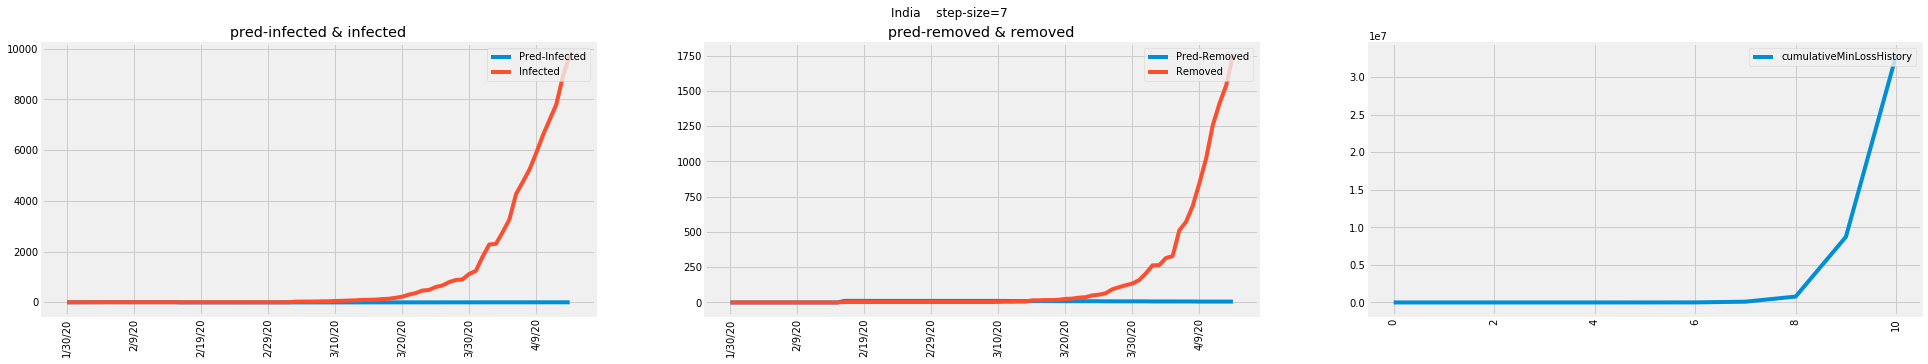

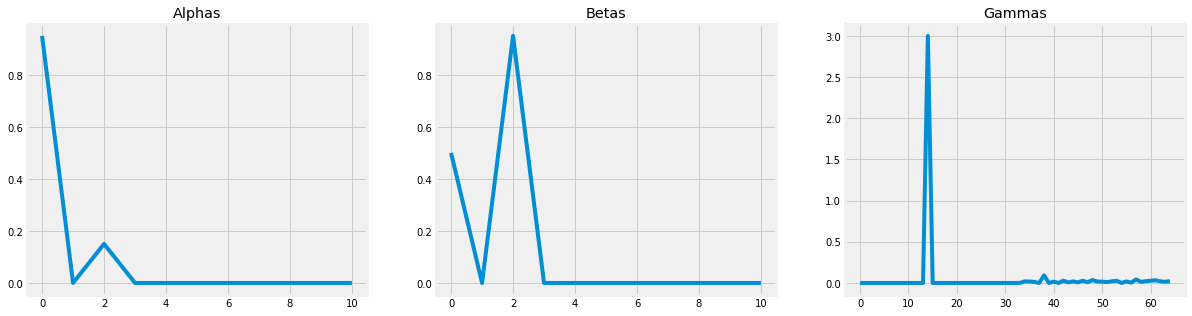

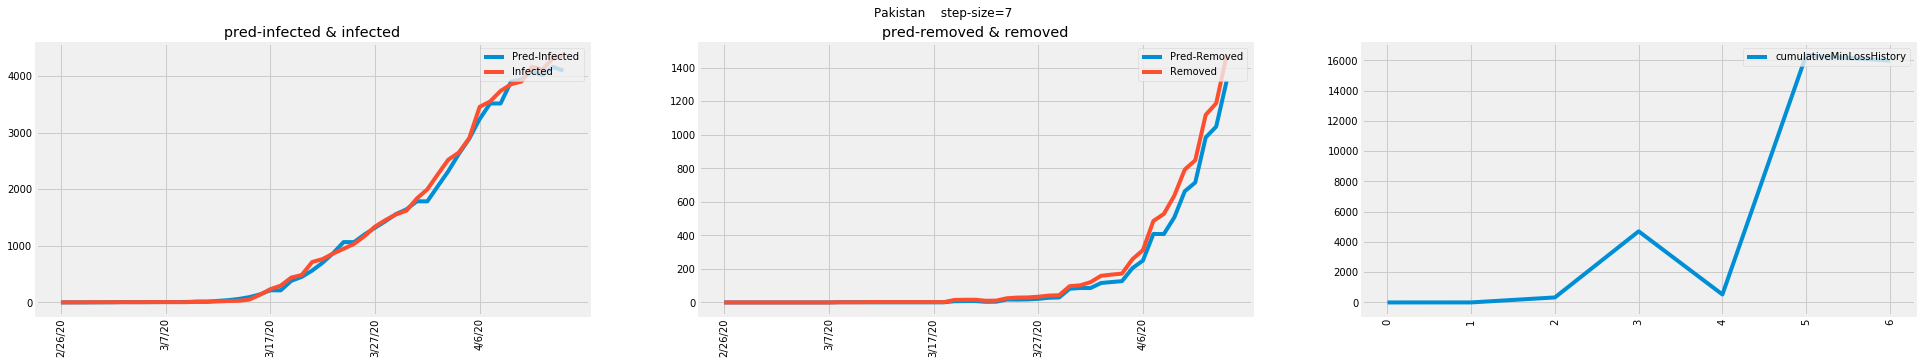

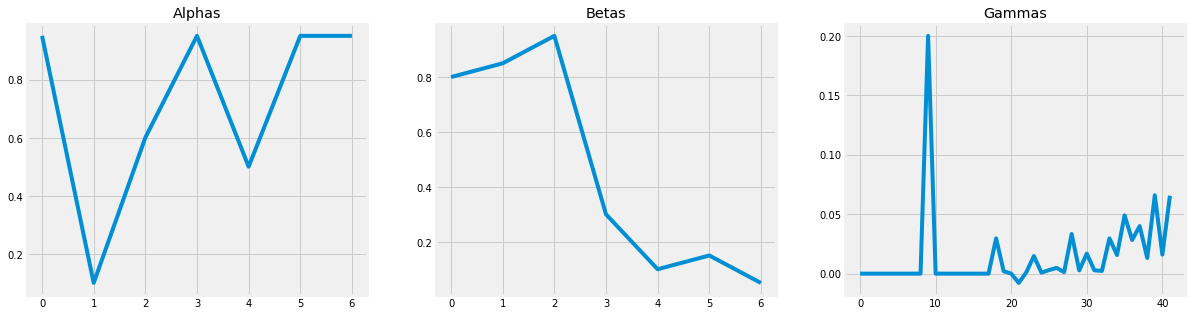

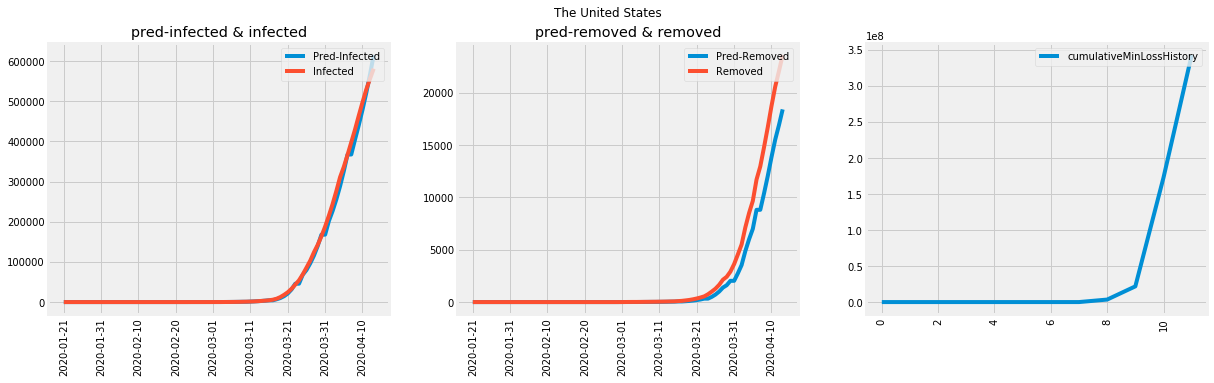

In [11]:
for stepSize in stepSizesToRunFor:
        computeParamsWithStepSize(stepSize)

In [12]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,10))
cumulativeLossDf['Accuracy_Score'] = min_max_scaler.fit_transform(cumulativeLossDf['Accuracy_Score'].values.reshape(-1, 1))
cumulativeLossDf[cumulativeLossDf['Accuracy_Score'] == 0] = 0.0001
cumulativeLossDf['Accuracy_Score'] = 1/cumulativeLossDf['Accuracy_Score']

display(cumulativeLossDf)
cumulativeLossDf_group_by_stepSize = cumulativeLossDf.groupby('Step_Size').max()
cumulativeLossDf_group_by_stepSize = pd.DataFrame(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize.loc[cumulativeLossDf_group_by_stepSize['Accuracy_Score'].idxmax() ])

,Country,Accuracy_Score,Step_Size
0,India,0.585756,7.0
1,Pakistan,1.000000,7.0
2,The United States,0.100000,7.0


,Country,Accuracy_Score
Step_Size,,
7.0,The United States,1.0


Country           The United States
Accuracy_Score    1                
Name: 7.0, dtype: object